In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import matplotlib.ticker as mtick
import scirpy as ir
import os

sc.settings.verbosity = 3  
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80,fontsize=8, frameon=False, figsize=(3, 3), facecolor='white')

-----
anndata     0.8.0
scanpy      1.9.1
-----
Levenshtein                 5
PIL                         8.2.0
adjustText                  NA
airr                        1.4.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.2
cffi                        1.14.6
cloudpickle                 1.6.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2021.07.2
dateutil                    2.8.1
decorator                   5.0.9
fsspec                      2021.07.0
google                      NA
h5py                        3.7.0
igraph                      0.9.6
ipykernel                   6.1.0
ipython_genutils            0.2.0
ipywidgets                  7.6.3
jedi                        0.18.0
joblib                      1.0.1
kiwisolver                  1.3.1
leidenalg                   0.8.8
llvmlite                    0.39.1
louvai

In [2]:
os.chdir('/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/')

In [13]:
BLOOD_ALLCELLS_PATH = '/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/step6_validation/TCR/blood_py38_20221022.h5ad'
TUMOR_ALLCELLS_PATH = '/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/step6_validation/TCR/tumor_py38_20221022.h5ad'
BLOOD_TCELLS_PATH = '/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/step6_validation/TCR/T_tumor_py38_20221022.h5ad'
TUMOR_TCELLS_PATH = '/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/step6_validation/TCR/tissue_py38_20221010.h5ad'
DOUBLET_PATH = '/share/pub/zhangyr/projects/cooperation/SJTU/ESCC/results/step6_validation/TCR/doublets_20221010.csv'

In [15]:
def preprocessing(adata,filter_cells, barc = '-1'):
    sc.pp.filter_genes(adata, min_cells=0.001*adata.n_obs)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    adata.var['rb'] = adata.var_names.str.contains('^RP[SL]')
    adata.var['hb'] = adata.var_names.str.contains('^HB[APS]')
    adata.var['hsp'] = adata.var_names.str.contains('^HSP')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rb','hb','hsp'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts < 6000, :]
    adata = adata[adata.obs.n_genes_by_counts > 200, :]
    adata = adata[adata.obs.total_counts < 20000, :]
    adata = adata[adata.obs.pct_counts_mt < 10, :]
    pre_cell = len(adata.obs_names)
    adata = adata[~adata.obs.index.isin(filter_cells)]
    after_cell = len(adata.obs_names)
    print("{0} cells filtered by double and mix".format(pre_cell-after_cell) )
    return adata

def normalization(adata, n_top = 3000):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=n_top)
    #adata = adata[:, adata.var.highly_variable]
    sc.pp.regress_out(adata, ['total_counts', 'n_genes_by_counts', 
                              'pct_counts_mt','pct_counts_hsp'])
    sc.tl.pca(adata, svd_solver='arpack')
    return adata

## Major clusters
* Filtering, normalization, batch coorection, unsupervised clustering processes were same as 7 paired scRNA data sets

In [12]:
raw_folder = '/share2/pub/zhangyr/zhangyr/cooperation/SJTU/ESCC/Raw_data/validation_out'

tissue_rna_1 = sc.read_10x_mtx(os.path.join(raw_folder, './DOE2022889-b1_QC_report_20220314/PYYL/outs/filtered_feature_bc_matrix/'),cache=True)
pbmc_rna_1 = sc.read_10x_mtx(os.path.join(raw_folder, './DOE2022889-b1_QC_report_20220314/PBMC_N1_024/outs/filtered_feature_bc_matrix/'),cache=True)
tissue_rna_2 = sc.read_10x_mtx(os.path.join(raw_folder, './DOE2022889-b2_QC_Report_2022_04_20/N021_T/outs/filtered_feature_bc_matrix/'),cache=True)
pbmc_rna_2 = sc.read_10x_mtx(os.path.join(raw_folder, './DOE2022889-b2_QC_Report_2022_04_20/N021_B/outs/filtered_feature_bc_matrix/'),cache=True)



tissue_tcr_1 = ir.io.read_10x_vdj(os.path.join(raw_folder, './DOE2022889-b1-TCR_QC_report_20220314/PYYL_TCR/outs/filtered_contig_annotations.csv'))
pbmc_tcr_1 = ir.io.read_10x_vdj(os.path.join(raw_folder, './DOE2022889-b1-TCR_QC_report_20220314/PBMC_N1_024_TCR/outs/filtered_contig_annotations.csv'))
tissue_tcr_2 = ir.io.read_10x_vdj(os.path.join(raw_folder, './DOE2022889-b2-TCR_QC_report_2022_04_20/N021_T_TCR/filtered_contig_annotations.csv'))
pbmc_tcr_2 = ir.io.read_10x_vdj(os.path.join(raw_folder, './DOE2022889-b2-TCR_QC_report_2022_04_20/N021_B_TCR/filtered_contig_annotations.csv'))


ir.pp.merge_with_ir(tissue_rna_1, tissue_tcr_1)
ir.pp.merge_with_ir(pbmc_rna_1, pbmc_tcr_1)
ir.pp.merge_with_ir(tissue_rna_2, tissue_tcr_2)
ir.pp.merge_with_ir(pbmc_rna_2, pbmc_tcr_2)

... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time
... writing an h5ad cache file to speedup reading next time


... storing 'feature_types' as categorical
... storing 'feature_types' as categorical
... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


In [19]:
doublet = pd.read_csv(DOUBLET_PATH)
doublet = list(doublet.iloc[:,1])

tissue_rna_1 = preprocessing(tissue_rna_1,doublet)
pbmc_rna_1 = preprocessing(pbmc_rna_1,doublet)
tissue_rna_2 = preprocessing(tissue_rna_2,doublet)
pbmc_rna_2 = preprocessing(pbmc_rna_2,doublet)

tumor = tissue_rna_1.concatenate(tissue_rna_2, batch_categories=['P024', 'P021'],batch_key = 'sample')
blood = pbmc_rna_1.concatenate(pbmc_rna_2, batch_categories=['P024', 'P021'],batch_key = 'sample')

tumor.raw = tumor
blood.raw = blood

tumor = normalization(tumor)
blood = normalization(blood)

sc.external.pp.bbknn(tumor, batch_key='sample')
sc.tl.umap(tumor)
sc.tl.leiden(tumor,resolution=0.3)

sc.external.pp.bbknn(blood, batch_key='sample')
sc.tl.umap(blood)
sc.tl.leiden(blood,resolution=0.3)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_hsp']
    sparse input is densified and may lead to high memory use


... storing 'IR_VJ_1_j_call' as categorical
... storing 'IR_VJ_2_j_call' as categorical
... storing 'IR_VDJ_2_j_call' as categorical
... storing 'IR_VJ_1_junction' as categorical
... storing 'IR_VJ_2_junction' as categorical
... storing 'IR_VDJ_1_junction' as categorical
... storing 'IR_VDJ_2_junction' as categorical
... storing 'IR_VJ_1_junction_aa' as categorical
... storing 'IR_VJ_2_junction_aa' as categorical
... storing 'IR_VDJ_1_junction_aa' as categorical
... storing 'IR_VDJ_2_junction_aa' as categorical
... storing 'IR_VJ_2_v_call' as categorical
... storing 'IR_VDJ_1_v_call' as categorical
... storing 'IR_VDJ_2_v_call' as categorical


    finished (0:04:27)
computing PCA
    on highly variable genes
    with n_comps=50


/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


    finished (0:00:09)
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_hsp']
    sparse input is densified and may lead to high memory use


... storing 'IR_VJ_2_j_call' as categorical
... storing 'IR_VDJ_2_j_call' as categorical
... storing 'IR_VJ_1_junction' as categorical
... storing 'IR_VJ_2_junction' as categorical
... storing 'IR_VDJ_1_junction' as categorical
... storing 'IR_VDJ_2_junction' as categorical
... storing 'IR_VJ_1_junction_aa' as categorical
... storing 'IR_VJ_2_junction_aa' as categorical
... storing 'IR_VDJ_1_junction_aa' as categorical
... storing 'IR_VDJ_2_junction_aa' as categorical
... storing 'IR_VJ_1_v_call' as categorical
... storing 'IR_VJ_2_v_call' as categorical
... storing 'IR_VDJ_1_v_call' as categorical
... storing 'IR_VDJ_2_v_call' as categorical


    finished (0:04:33)
computing PCA
    on highly variable genes
    with n_comps=50


/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


    finished (0:00:13)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [3]:
tumor = sc.read_h5ad('./results/step6_validation/TCR/tumor_py38_20221022.h5ad')
tumor

AnnData object with n_obs × n_vars = 17299 × 17394
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'n_genes_by_count

/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


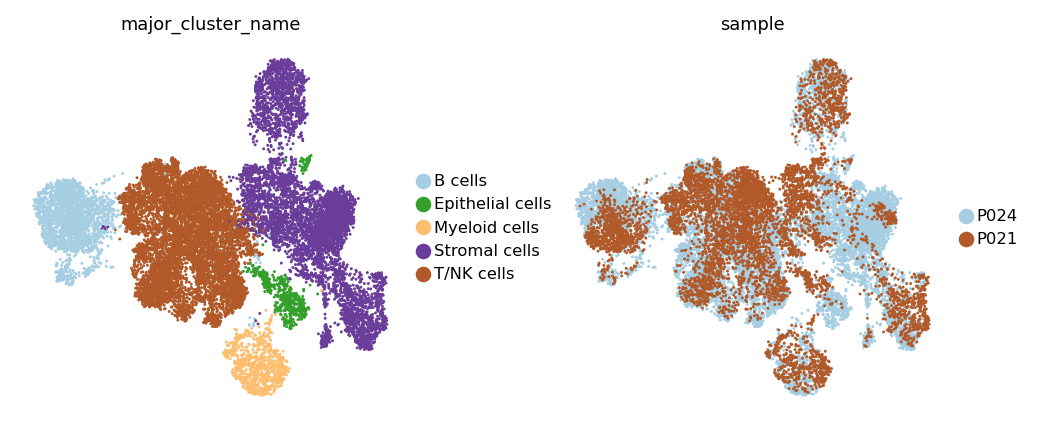

In [4]:
sc.pl.umap(tumor,color=['major_cluster_name','sample'])

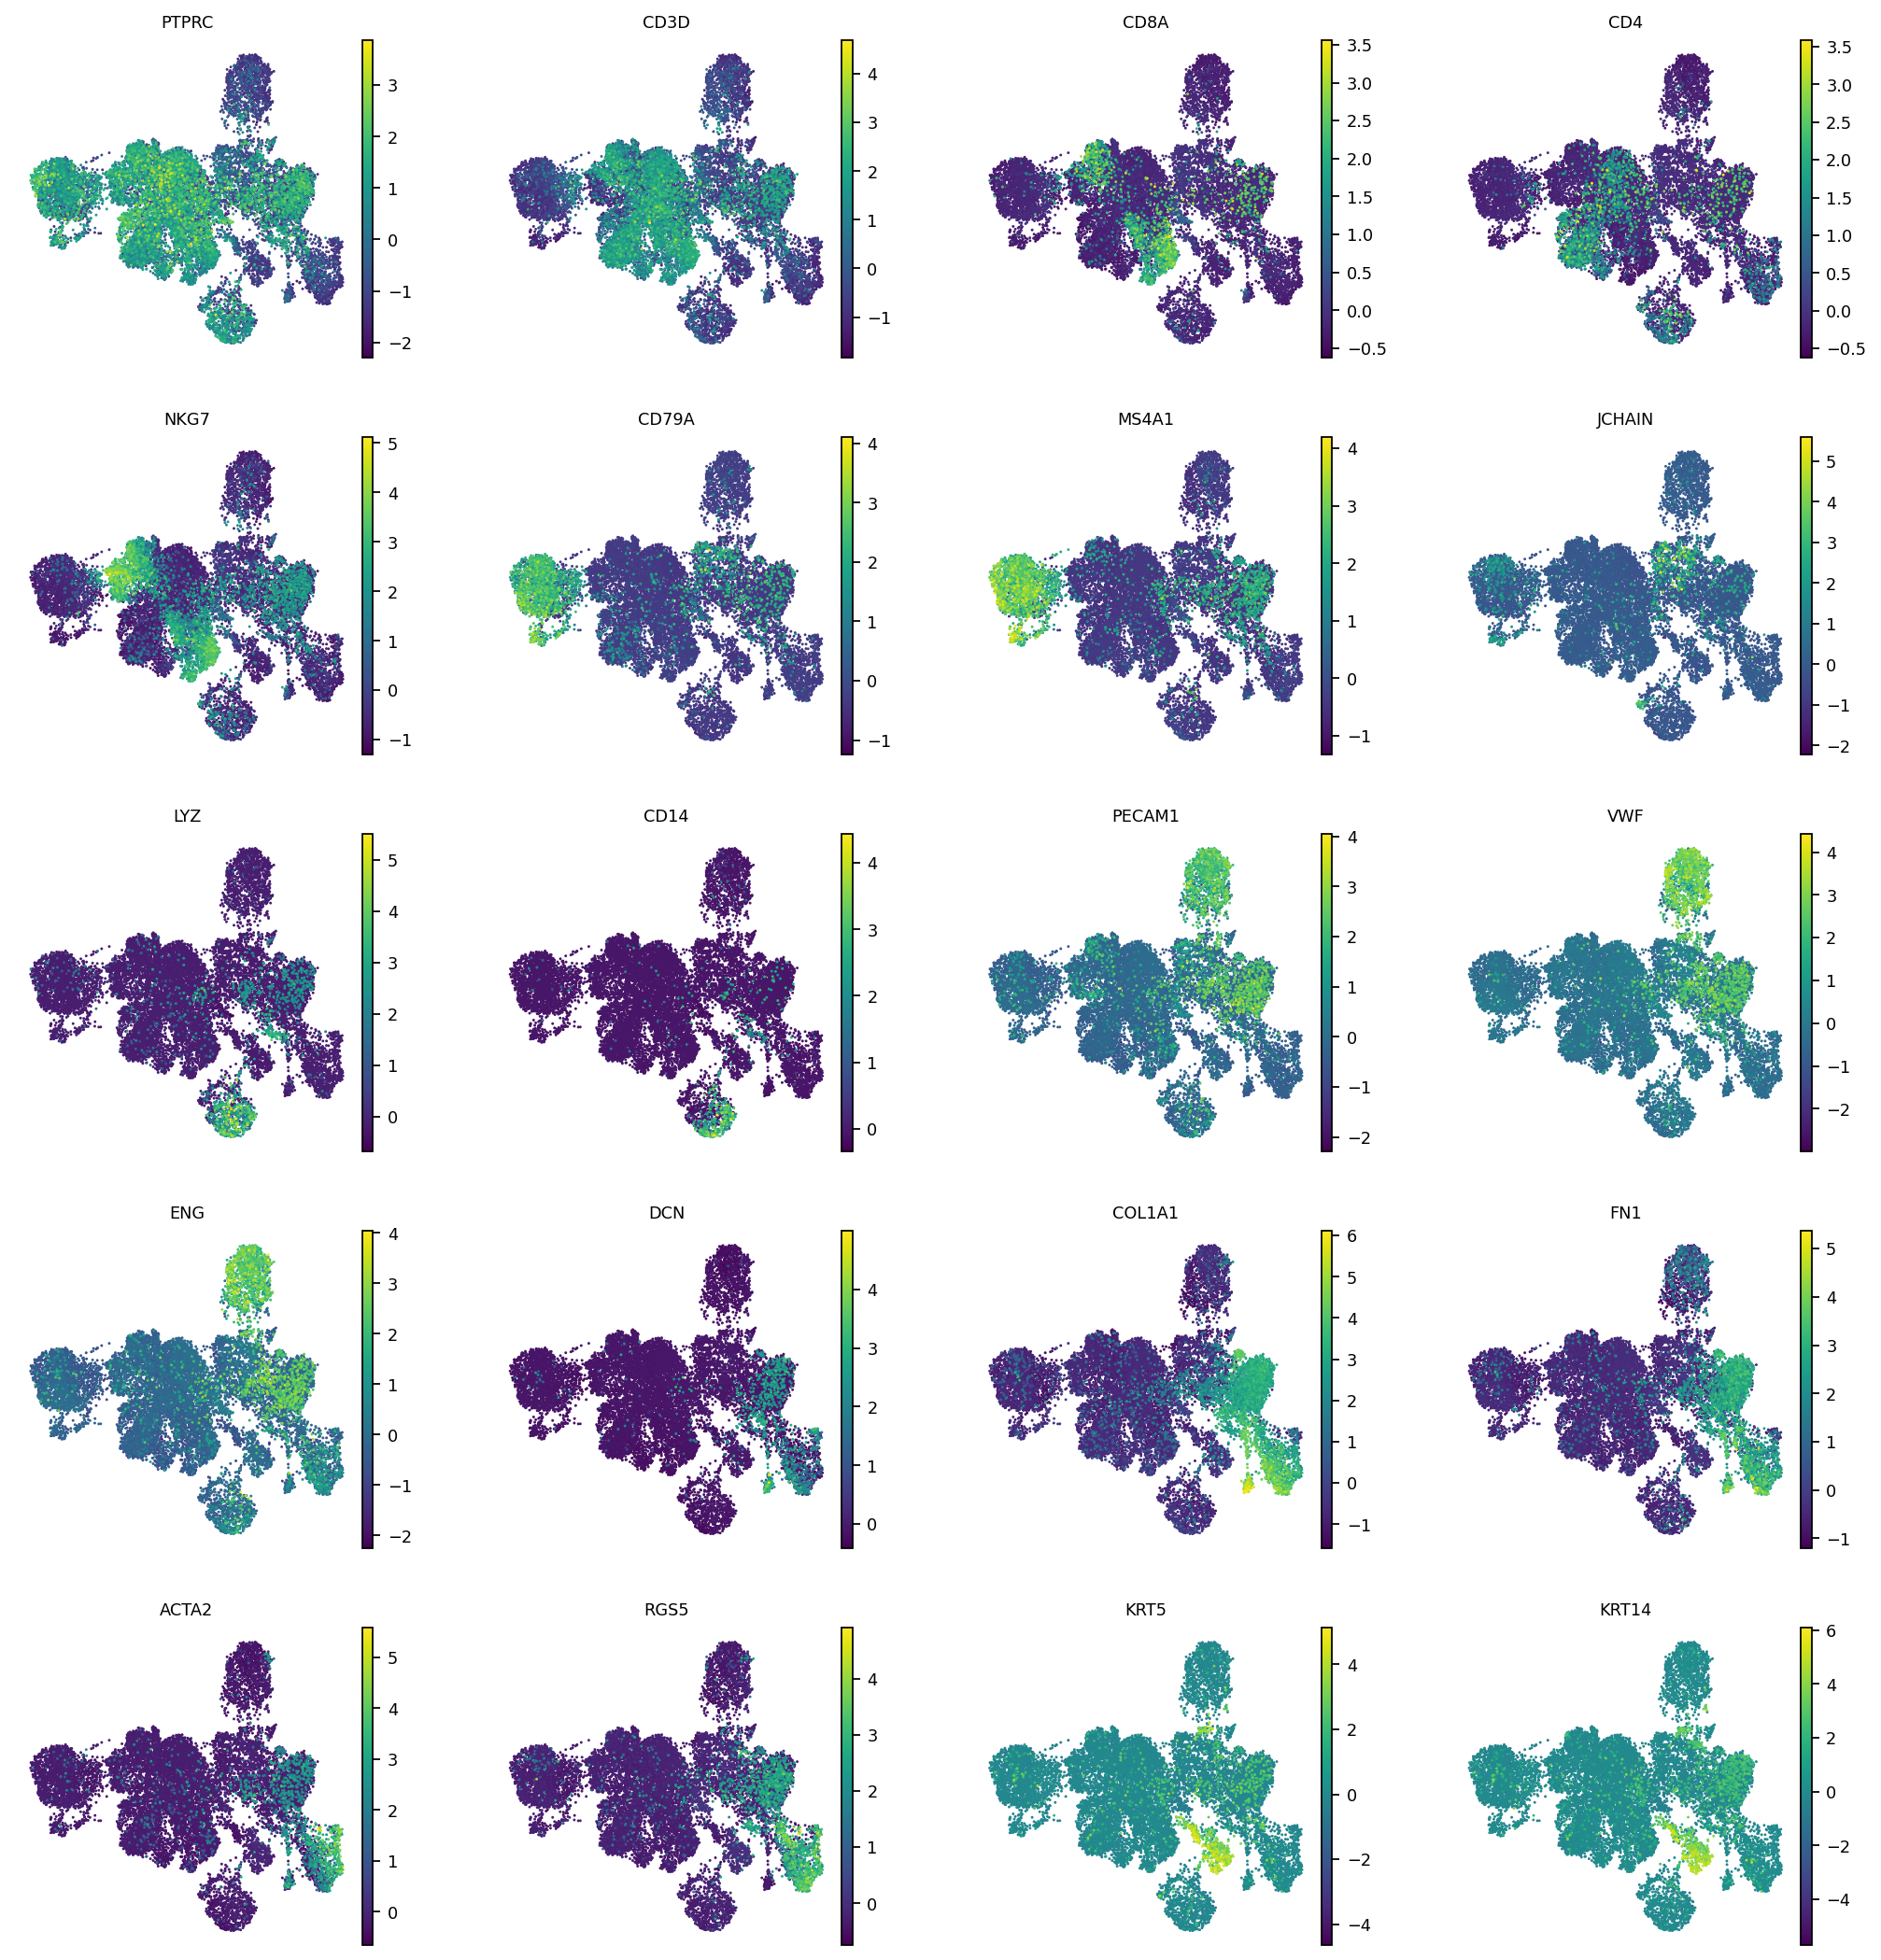

In [8]:
sc.pl.umap(tumor, color=['PTPRC','CD3D','CD8A','CD4','NKG7',
                         'CD79A','MS4A1','JCHAIN',
                         'LYZ','CD14',
                         'PECAM1','VWF','ENG',
                         'DCN','COL1A1','FN1',
                         'ACTA2','RGS5','KRT5','KRT14'
                        ],use_raw=False,ncols=4)

In [5]:
blood = sc.read_h5ad('./results/step6_validation/TCR/blood_py38_20221022.h5ad')
blood

AnnData object with n_obs × n_vars = 23718 × 15247
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'n_genes_by_count

/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/share/home/zhangyr/.conda/envs/web_jupyter/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


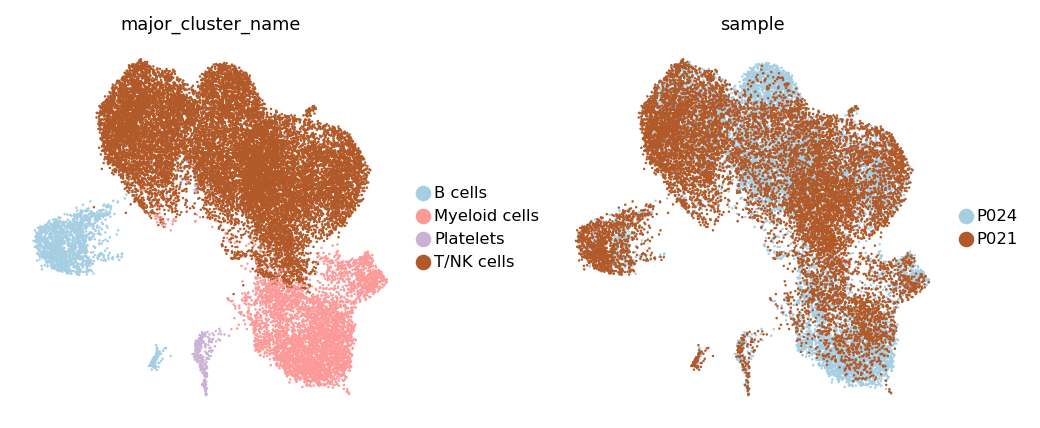

In [6]:
sc.pl.umap(blood,color=['major_cluster_name','sample'])

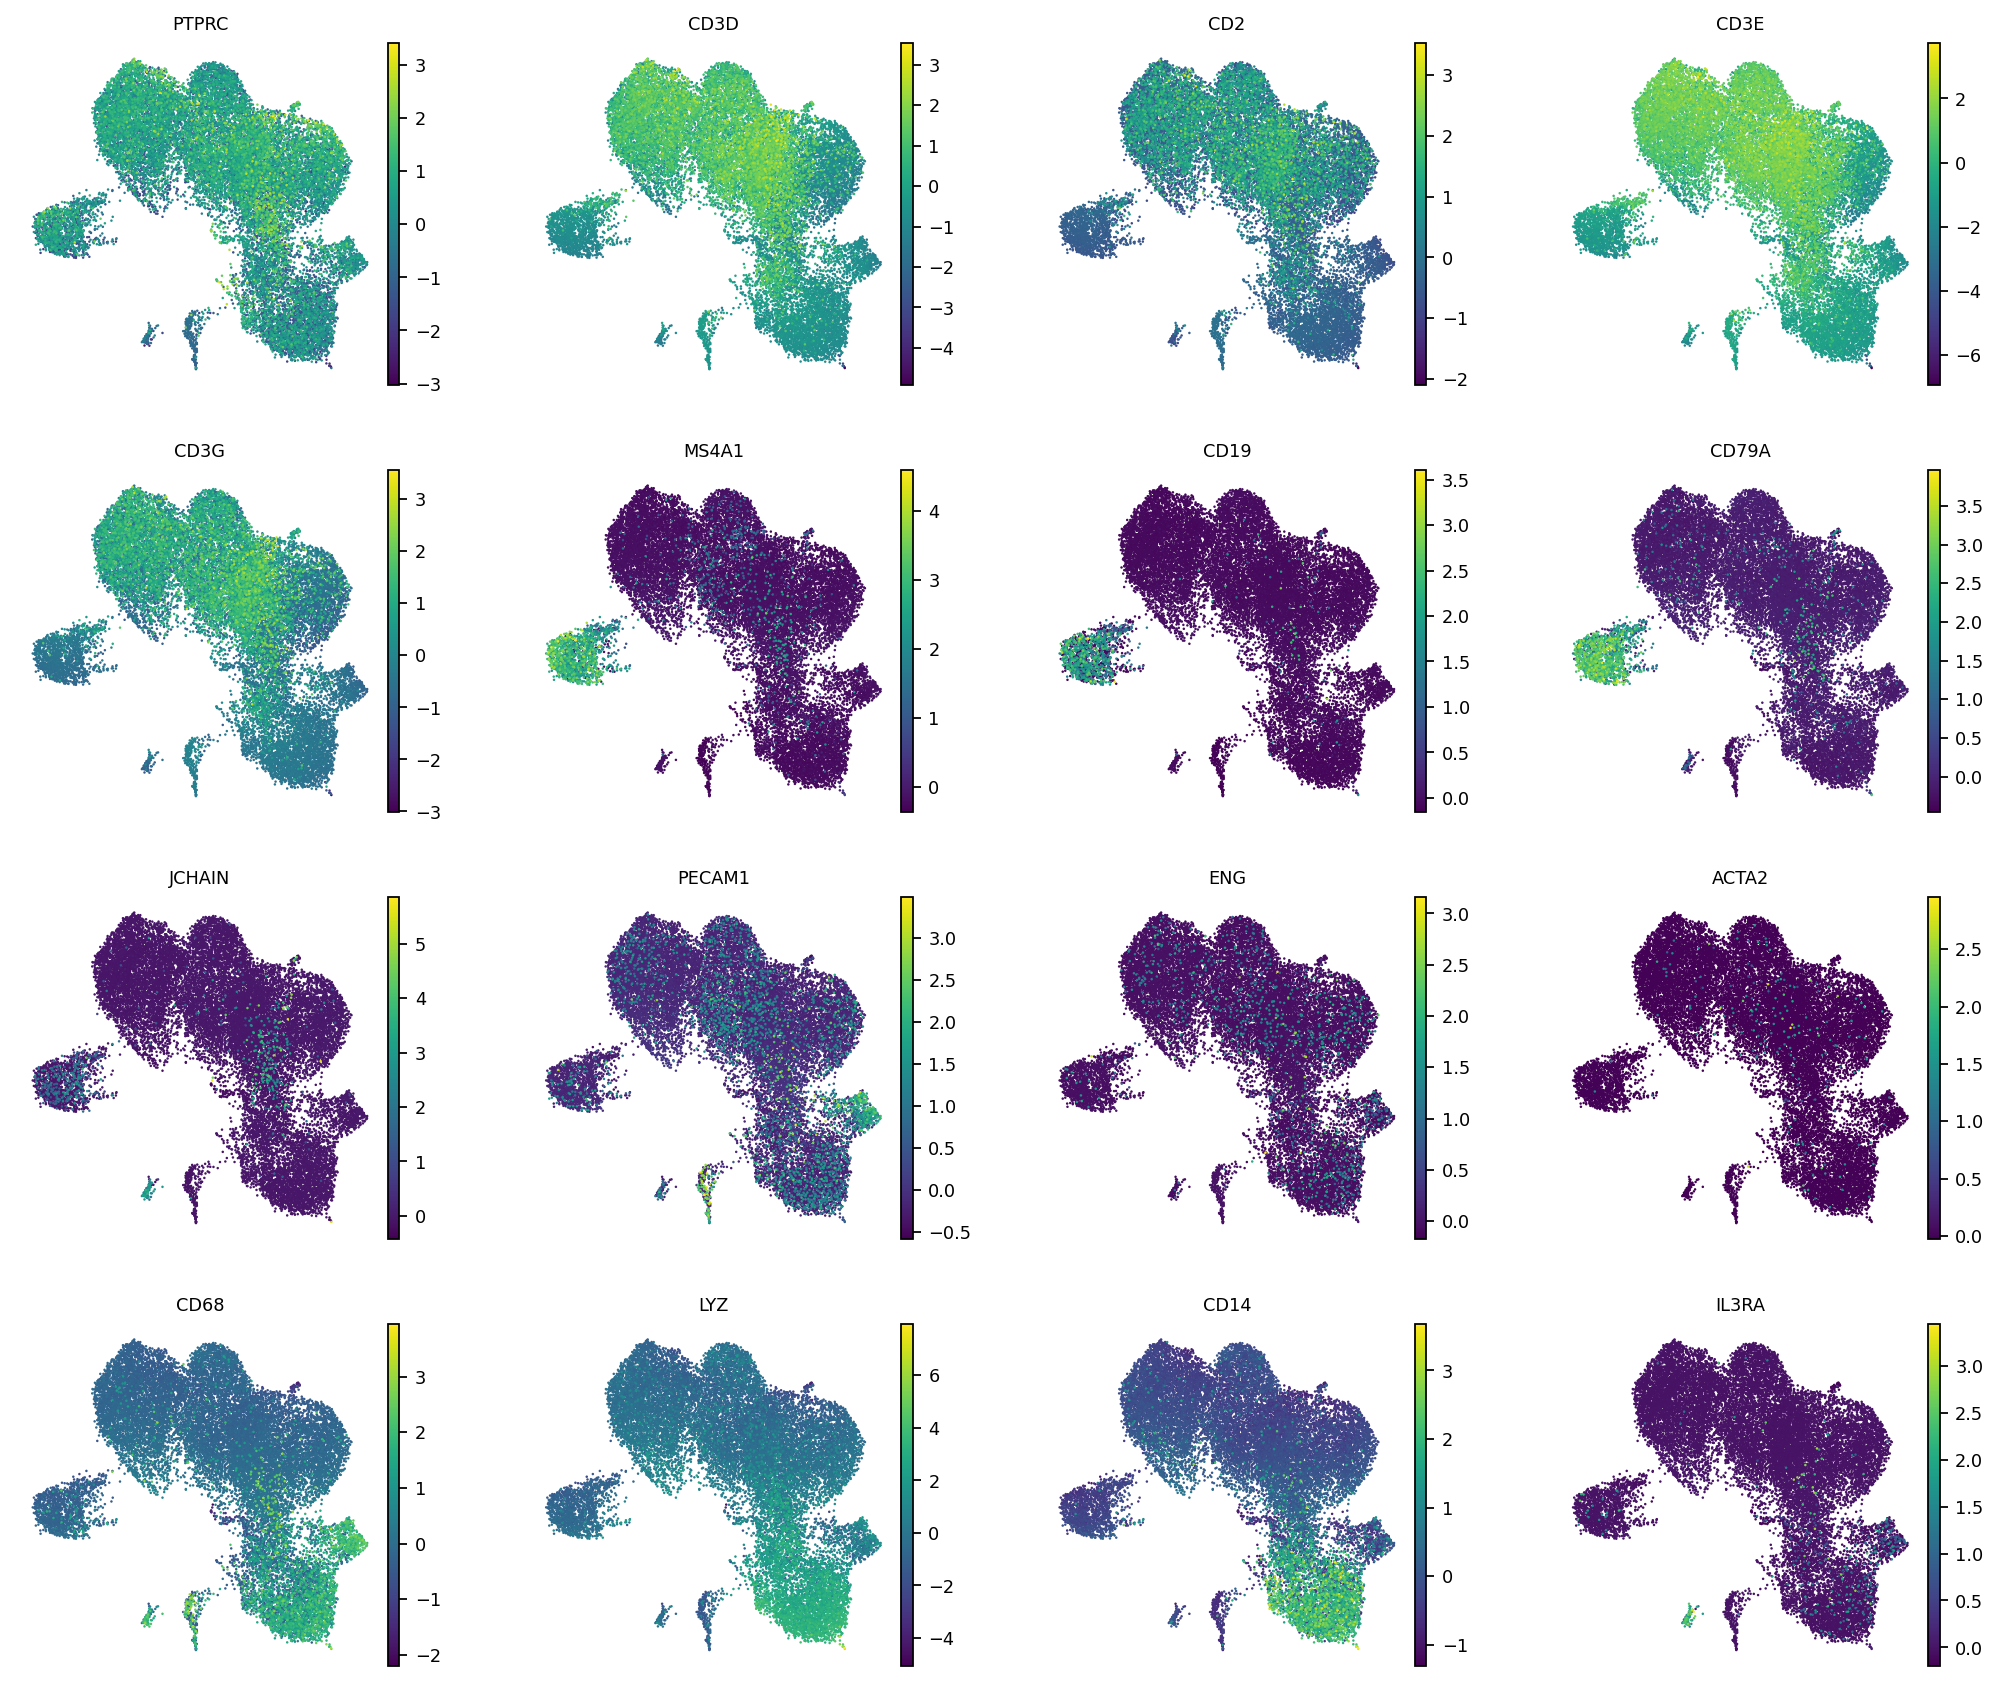

In [9]:
sc.pl.umap(blood, color = ["PTPRC",
                "CD3D","CD2","CD3E","CD3G",   ## T cell
                'MS4A1',"CD19","CD79A","JCHAIN",  ## B cell
                #'DCN',  ## fibroblast
                "PECAM1","ENG",    ## endothelial cell
                 "ACTA2",    ## pericyte
                "CD68","LYZ","CD14","IL3RA"] ,use_raw=False,ncols=4)